In [1]:
%load_ext autoreload
%autoreload 2

import autoreg as nb
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from statsmodels.tsa.ar_model import AutoReg
import nibabel as nib

from src import plts, acf_utils

# set notebook default
cmap = "viridis"

**Yule-Walker equations for AR(2)**

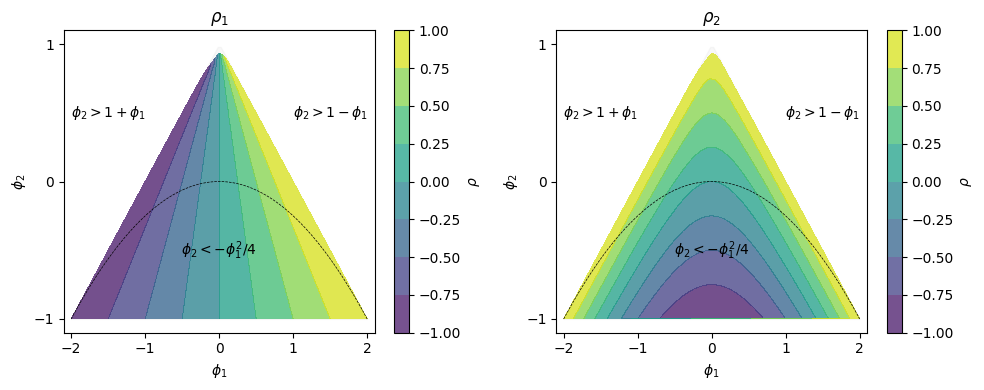

In [2]:
def gen_ar2_coeffs(random_seed=0):
    rng = np.random.default_rng(seed=random_seed)
    phi1 = rng.uniform(-2, 2)
    phi2 = rng.uniform(-1, np.min([1 + phi1, 1 - phi1]))
    return phi1, phi2


rho1 = lambda phi1, phi2: phi1 / (1 - phi2)
rho2 = lambda phi1, phi2: (phi1**2 - phi2**2 + phi2) / (1 - phi2)

phis = np.array([gen_ar2_coeffs(random_seed=idx) for idx in range(5000)])
rho1s = rho1(phis[:, 0], phis[:, 1])
rho2s = rho2(phis[:, 0], phis[:, 1])

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
kwargs = dict(alpha=0.75, cmap=cmap)

axs[0].set_title(r"$\rho_1$")
plts.plot_stationarity_triangle(axs[0], fill_alpha=0.05)
contour1 = axs[0].tricontourf(phis[:, 0], phis[:, 1], rho1s, **kwargs)
fig.colorbar(contour1, ax=axs[0], label=r"$\rho$")

axs[1].set_title(r"$\rho_2$")
plts.plot_stationarity_triangle(axs[1], fill_alpha=0.05)
contour2 = axs[1].tricontourf(phis[:, 0], phis[:, 1], rho2s, **kwargs)
fig.colorbar(contour2, ax=axs[1], label=r"$\rho$")
fig.tight_layout()

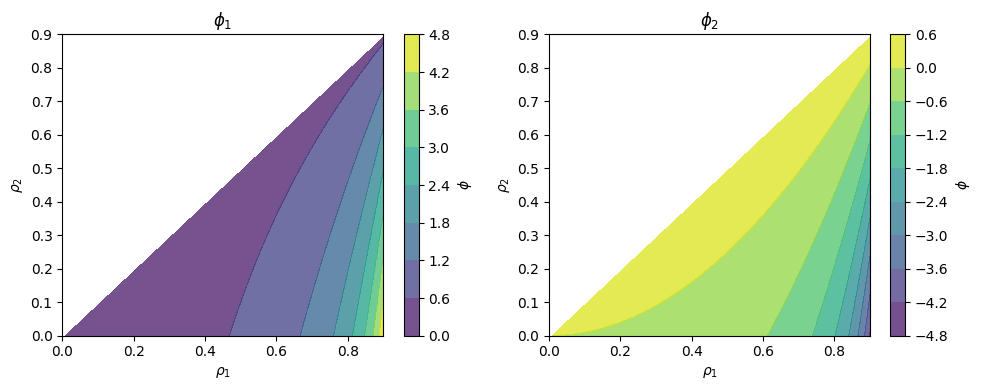

In [3]:
phi1 = lambda rho1, rho2: (rho1 - rho1 * rho2) / (1 - rho1**2)
phi2 = lambda rho1, rho2: ((-(rho1**2)) + rho2) / (1 - rho1**2)

rho1s, rho2s = np.linspace(0, 0.9, 100), np.linspace(0, 0.9, 100)
rho1s, rho2s = np.meshgrid(rho1s, rho2s)

# mask non-stationary acfs
mask = rho1s <= rho2s
phi1s = np.where(mask, np.nan, phi1(rho1s, rho2s))
phi2s = np.where(mask, np.nan, phi2(rho1s, rho2s))

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
kwargs = dict(alpha=0.75, cmap=cmap)

axs[0].set_title(r"$\phi_1$")
axs[0].set_xlabel(r"$\rho_1$")
axs[0].set_ylabel(r"$\rho_2$")
contour1 = axs[0].contourf(rho1s, rho2s, phi1s, **kwargs)
fig.colorbar(contour1, ax=axs[0], label=r"$\phi$")

axs[1].set_title(r"$\phi_2$")
axs[1].set_xlabel(r"$\rho_1$")
axs[1].set_ylabel(r"$\rho_2$")
contour2 = axs[1].contourf(rho1s, rho2s, phi2s, **kwargs)
fig.colorbar(contour2, ax=axs[1], label=r"$\phi$")
fig.tight_layout()

**simulation: gaussian filter**

Text(0, 0.5, '$\\rho_2$')

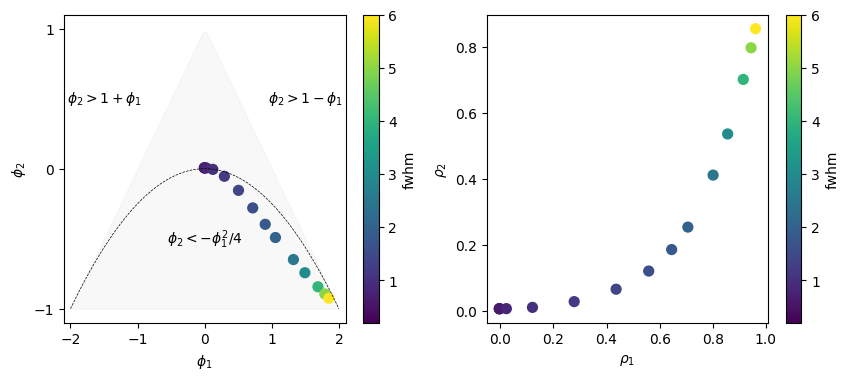

In [4]:
n_timepoints = 5000
fwhms = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 4, 5, 6]

acf = acf_utils.ACF()
rng = np.random.default_rng(seed=0)
Z_wn = rng.standard_normal(size=n_timepoints)

ar_coeffs = np.zeros(shape=(len(fwhms), 2))
corr_coeffs = np.zeros(shape=(len(fwhms), 2))
for idx, fwhm in enumerate(fwhms):
    std = fwhm / (2 * np.sqrt(2 * np.log(2)))
    X_smoothed = nb.smooth_signal(Z_wn, std=std)
    ar_fit = AutoReg(X_smoothed, lags=2, trend="n").fit()
    ar_coeffs[idx, :] = ar_fit.params
    X_smoothed_acf = acf.fit_transform(X_smoothed.reshape(-1, 1), n_timepoints).squeeze()
    corr_coeffs[idx, :] = X_smoothed_acf[1:3]


fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

plts.plot_stationarity_triangle(axs[0], fill_alpha=0.05)
sc1 = axs[0].scatter(ar_coeffs[:, 0], ar_coeffs[:, 1], s=50, c=fwhms, cmap=cmap)
fig.colorbar(sc1, ax=axs[0], label=r"fwhm")

sc2 = axs[1].scatter(corr_coeffs[:, 0], corr_coeffs[:, 1], s=50, c=fwhms, cmap=cmap)
fig.colorbar(sc2, ax=axs[1], label=r"fwhm")
axs[1].set_xlabel(r"$\rho_1$")
axs[1].set_ylabel(r"$\rho_2$")

**HCP dataset: parcellation**

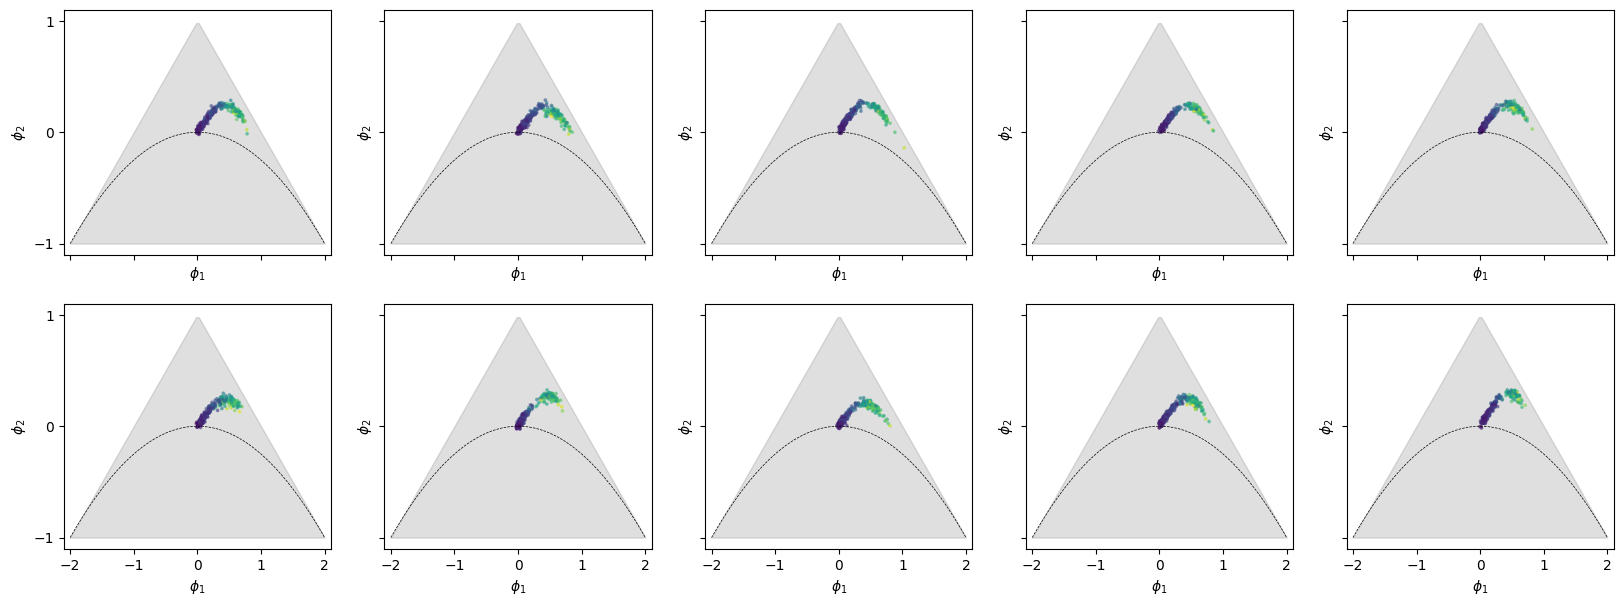

In [5]:
# !!! 10 sec runtime !!!


def fit_ar2(X, idx):
    ar_fit = AutoReg(X[:, idx], lags=2, trend="n").fit()
    return ar_fit.params


def fit_poly(ar_coeffs):
    lm_coeffs = np.polyfit(x=ar_coeffs[:, 0], y=ar_coeffs[:, 1], deg=2)
    return np.poly1d(lm_coeffs)


n_subjects, n_regions, n_timepoints = 10, 300, 4800
region_sizes = np.load("./data/nregions-300_sizes.npy")
Xs = np.load("./data/nsubjects-10_nregions-300_hcp.npy").astype(np.float32)

fig, axs = plt.subplots(nrows=2, ncols=n_subjects // 2, figsize=(20, 7), sharex=True, sharey=True)
axs = axs.flatten()

poly_fits = []
for idx, ax in enumerate(axs):
    X = Xs[idx]
    ar_coeffs = np.array(
        Parallel(n_jobs=-1)(delayed(fit_ar2)(X, region) for region in range(n_regions))
    )
    plts.plot_stationarity_triangle(ax, annotate=False)
    ax.scatter(ar_coeffs[:, 0], ar_coeffs[:, 1], s=3, alpha=0.5, c=region_sizes, cmap=cmap)
    poly_fits.append(fit_poly(ar_coeffs))

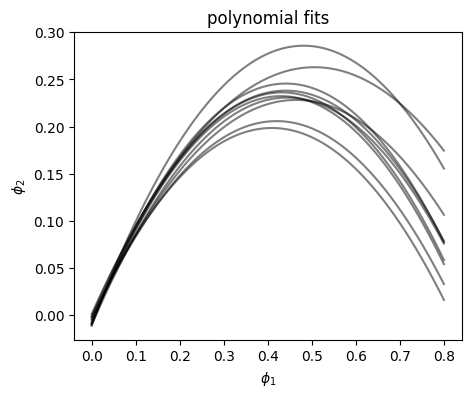

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title("polynomial fits")
ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")
x = np.linspace(0, 0.8, 100)
for poly_fit in poly_fits:
    ax.plot(x, poly_fit(x), c="k", alpha=0.5)

linear model coefficients:  [0.863 0.832 0.883 0.866 0.873 0.859 0.898 0.813 0.863 0.92 ]


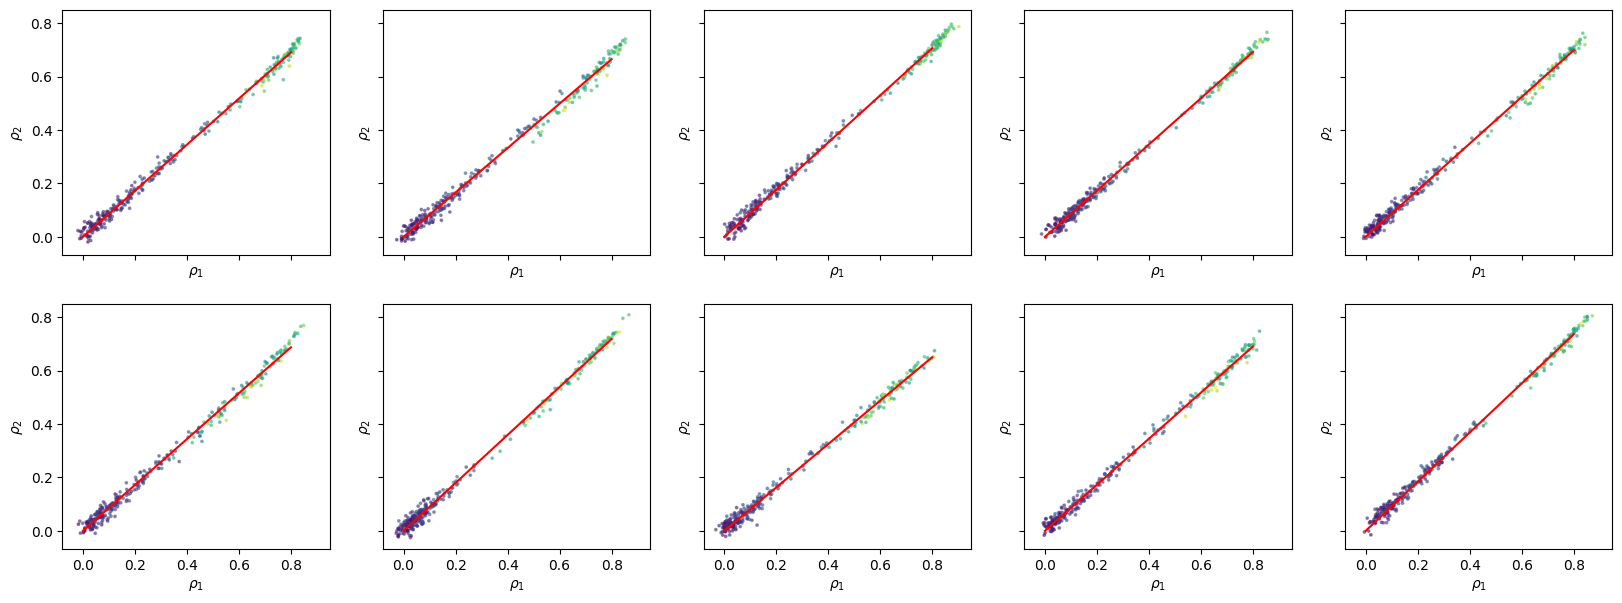

In [7]:
def fit_lm(rho1s, rho2s):
    return np.sum((rho1s * rho2s), axis=0) / np.sum(rho1s**2, axis=0)


fig, axs = plt.subplots(nrows=2, ncols=n_subjects // 2, figsize=(20, 7), sharex=True, sharey=True)
axs = axs.flatten()

x = np.linspace(0, 0.8, 100)
lm_fits = []

for idx, ax in enumerate(axs):
    X = Xs[idx]
    X_acf = acf.fit_transform(X, n_timepoints)
    ax.scatter(X_acf[1, :], X_acf[2, :], s=3, alpha=0.5, c=region_sizes, cmap=cmap)
    ax.set_xlabel(r"$\rho_1$")
    ax.set_ylabel(r"$\rho_2$")

    lm_fit = fit_lm(X_acf[1, :], X_acf[2, :])
    lm_fits.append(lm_fit)
    ax.plot(x, lm_fit * x, color="r")

print("linear model coefficients: ", np.round(lm_fits, 3))

**HCP dataset: 7T CIFTI**

In [8]:
dtseries = "./data/hcp7T.dtseries.nii"
cifti = nib.cifti2.load(dtseries)
X = cifti.get_fdata(dtype=np.float32)
X = (X - X.mean(axis=0)) / X.std(axis=0)

n_coordinates = X.shape[1]

ar_coeffs = np.array(Parallel(n_jobs=-1)(delayed(fit_ar2)(X, idx) for idx in range(n_coordinates)))
poly_fit = fit_poly(ar_coeffs)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


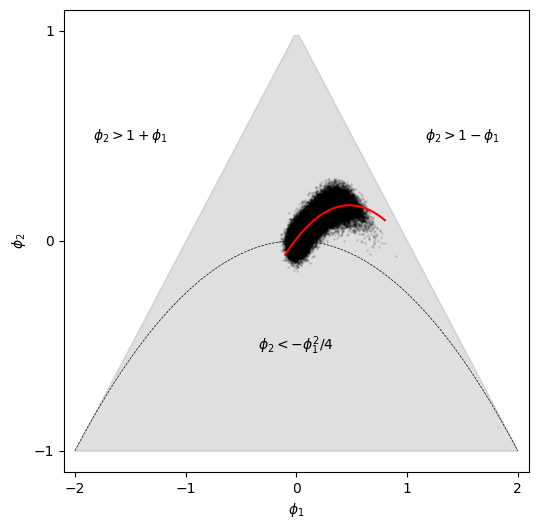

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
plts.plot_stationarity_triangle(ax)
ax.scatter(ar_coeffs[:, 0], ar_coeffs[:, 1], s=1, alpha=0.1, c="k")
x = np.linspace(-0.1, 0.8, 100)
ax.plot(x, poly_fit(x), c="r")